## Аналитика в Яндекс.Афише

Задачи проекта: помочь маркетологам оптимизировать маркетинговые затраты. Имеются данные от Яндекс.Афиши с июня 2017 по конец мая 2018 года. Нужно изучить как люди пользуются продуктом, когда они начинают покупать, сколько денег приносит каждый клиент и когда клиент окупается.

### Оглавление
1. [Загрузка и предобработка данных](#1)  
2. [Рассчет метрик продукта.](#2)  
    2.1. [Сколько людей пользуются в день, неделю, месяц?](#21)  
    2.2. [Сколько сессий в день?](#22)  
    2.3. [Сколько длится одна сессия?](#23)  
    2.4. [Как часто люди возвращаются?](#24)
3. [Рассчет метрик продаж.](#3)  
    3.1. [Когда люди начинают покупать?](#31)  
    3.2. [Сколько раз покупают за период?](#32)  
    3.3. [Какой средний чек?](#33)  
    3.4. [Сколько денег приносят? (LTV)](#34)
4. [Рассчет метрик маркентина.](#4)  
    4.1. [Сколько денег потратили? Всего / на каждый источник / по времени](#41)  
    4.2. [Сколько стоило привлечение одного покупателя из каждого источника? (CAC)](#42)  
    4.3. [На сколько окупились расходы? (ROMI)](#43)  
5. [Общий вывод](#5)

### <a id='1'></a> 1. Загрузка и предобработка данных

In [38]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.dates as mdates
from matplotlib import pyplot as plt
from IPython.display import display, HTML, Markdown

In [39]:
visits = pd.read_csv('datasets/visits_log.csv')
orders = pd.read_csv('datasets/orders_log.csv')
costs = pd.read_csv('datasets/costs.csv')

In [40]:
display(Markdown('#### Таблица visits: информация о посещениях сайта'))
print(visits.info())
display(HTML(visits.head().to_html()))

#### Таблица visits: информация о посещениях сайта

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Device     359400 non-null  object
 1   End Ts     359400 non-null  object
 2   Source Id  359400 non-null  int64 
 3   Start Ts   359400 non-null  object
 4   Uid        359400 non-null  uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB
None


,Device,End Ts,Source Id,Start Ts,Uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168


In [41]:
display(Markdown('#### Таблица orders: информация о заказах'))
print(orders.info())
display(HTML(orders.head().to_html()))

#### Таблица orders: информация о заказах

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Buy Ts   50415 non-null  object 
 1   Revenue  50415 non-null  float64
 2   Uid      50415 non-null  uint64 
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB
None


,Buy Ts,Revenue,Uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


In [42]:
display(Markdown('#### Таблица costs: информация о затратах на маркетинг'))
print(costs.info())
display(HTML(costs.head().to_html()))

#### Таблица costs: информация о затратах на маркетинг

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   source_id  2542 non-null   int64  
 1   dt         2542 non-null   object 
 2   costs      2542 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB
None


,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08


In [43]:
#изменим названия столбцов: приведем все буквы к нижнему регистру 
#и заменим пробелы на знак нижнего подчеркивания

for table in (visits, orders):
    table.columns = table.columns.str.lower()
    table.columns = table.columns.str.replace(' ', '_')

#изменим тип данных колонок, содержащих дату, на datetime
convert_to_date = [(visits, 'end_ts'),
                   (visits, 'start_ts'), 
                   (orders, 'buy_ts'), 
                   (costs, 'dt')]

for data in convert_to_date:
    data[0][data[1]] = (pd.to_datetime(data[0][data[1]], format='%Y-%m-%d'))
    
#оставим в orders только данные по 31.05.2017    
orders = orders[orders['buy_ts'] < '2018-06-01']

#### Выводы
В таблицах visits и costs содержатся данные с 01.06.2017 по 31.05.2018, поэтому оставим в таблице orders данные только за этот промежуток.

### <a id='2'></a>2. Рассчет метрик продукта

In [44]:
#добавим дополнительные колонки для рассчета метрик
visits['session_year'] = visits['start_ts'].astype('datetime64[Y]')
visits['session_month'] = visits['start_ts'].astype('datetime64[M]')
visits['session_date'] = visits['start_ts'].astype('datetime64[D]')
visits['session_week'] = (visits['session_date'] -
                          pd.to_timedelta(visits['start_ts'].dt.dayofweek, unit='d'))


#### <a id='21'></a>2.1. Сколько людей пользуются в день, неделю, месяц?

In [45]:
#Посчитаем количество уникальных пользователей: в день (DAU), в неделю (WAU), в месяц(MAU)
dau_total = round(visits.groupby('session_date')['uid'].nunique().mean())

wau_total = round(visits.groupby('session_week')['uid'].nunique().mean())

mau_total = round(visits.groupby('session_month')['uid'].nunique().mean())

#посчитаем регулярность использования сайта
sticky_factor_mau = round((dau_total / mau_total)*100)
sticky_factor_wau = round((dau_total / wau_total)*100)

print('Среднее количество уникальных пользователей в день (DAU):', dau_total)
print('Среднее количество уникальных пользователей в неделю (WAU):', wau_total)
print('среднее количество уникальных пользователей в месяц (MAU):', mau_total)
print('Sticky factor за неделю: {}%'.format(sticky_factor_wau))
print('Sticky factor за месяц: {}%'.format(sticky_factor_mau))

Среднее количество уникальных пользователей в день (DAU): 908
Среднее количество уникальных пользователей в неделю (WAU): 5716
среднее количество уникальных пользователей в месяц (MAU): 23228
Sticky factor за неделю: 16%
Sticky factor за месяц: 4%


In [46]:
def make_plot_from_pivot(pivot_table, title, y_label):
    pivot_table.plot(figsize = (10,6), x_compat = True)
    plt.grid()

    #добавим заголовок, подписи осей
    plt.title(title, fontsize = 12)
    plt.xlabel('Дата', fontsize = 10)
    plt.ylabel(y_label, fontsize = 10)

    #зададим шаг, размер шрифта подписей по осям
    plt.xticks(fontsize = 10)
    plt.yticks(fontsize = 10)

    #зададим размер шрифта легенды
    plt.legend(fontsize = 10)
    
    #зададим шаг по оси x в один месяц, в формате "год-месяц"
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y %m"))

    plt.show()

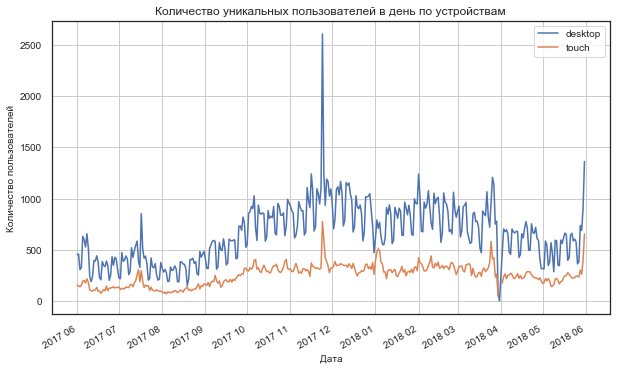

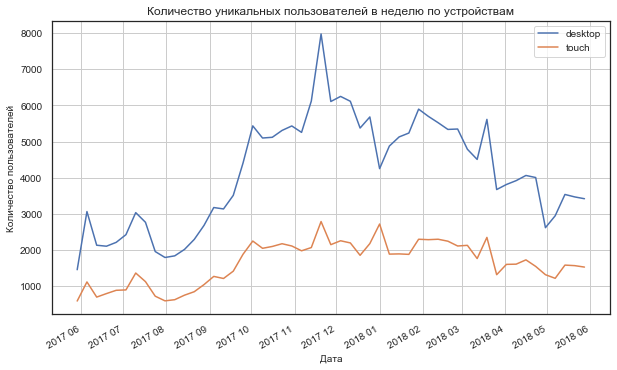

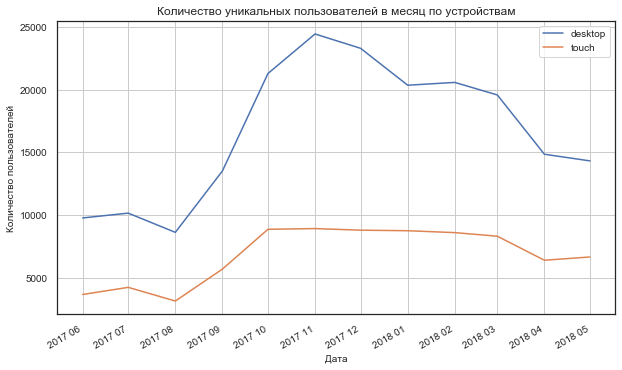

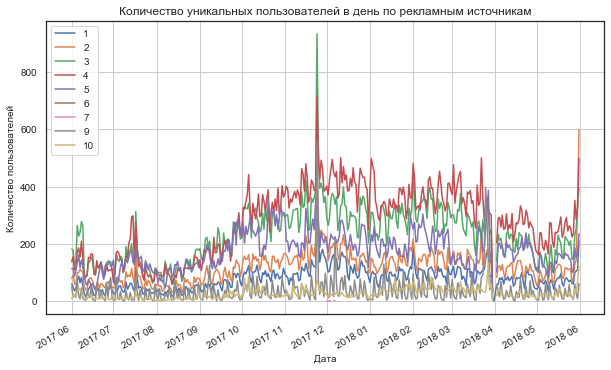

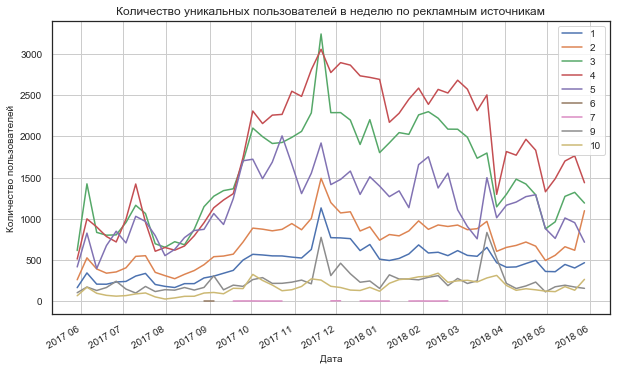

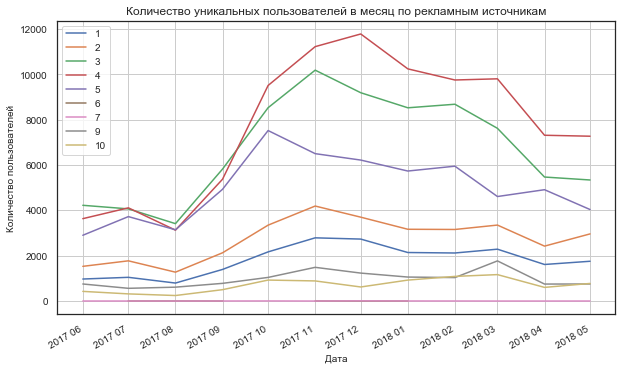

In [47]:
data_to_plot = [['session_date', 'device', 'Количество уникальных пользователей в день по устройствам', 'Количество пользователей'],
                ['session_week', 'device', 'Количество уникальных пользователей в неделю по устройствам', 'Количество пользователей' ],
                ['session_month', 'device', 'Количество уникальных пользователей в месяц по устройствам', 'Количество пользователей'],
                ['session_date', 'source_id', 'Количество уникальных пользователей в день по рекламным источникам', 'Количество пользователей'],
                ['session_week', 'source_id', 'Количество уникальных пользователей в неделю по рекламным источникам', 'Количество пользователей'],
                ['session_month', 'source_id', 'Количество уникальных пользователей в месяц по рекламным источникам', 'Количество пользователей']]

for data in data_to_plot:
    pivot_table = visits.pivot_table(
        index = data[0], 
        columns = data[1], 
        values = 'uid', 
        aggfunc = 'nunique')
    make_plot_from_pivot(pivot_table, data[2], data[3])


####  Выводы:
1. Низкий sticky factor означает, что в основном каждый день в приложение заходят новые пользователи (sticky factor за неделю - 16%, минимальное значение этой метрики - 14%, sticky factor за месяц - 4%, минимальное значение этой метрики - 3%). Пользователи редко заходят на сайт более одного раза в неделю и месяц.
2. Пользователи больше предпочитают desktop, чем touch.
3. Больше всего пользователей приходит из рекламных истоников 4, 3, 5.
4. Меньше всего пользователей приводит источник 9 и 10.
5. С сентября 2017 года наблюдается рост количества пользователей.
6. В конце ноября был резкий всплеск количества новых пользоватей.
7. 31 марта 2018 г. на сайт зашел 1 человек - возможно сайт в этот день был недоступен.
8. 24 ноября 2017 г. на сайт зашло рекордное количество посетителей - возможно в этот день была открыта продажа билетов на крупный концерт или была проведена акция.

#### <a id='22'></a>2.2. Сколько сессий в день?

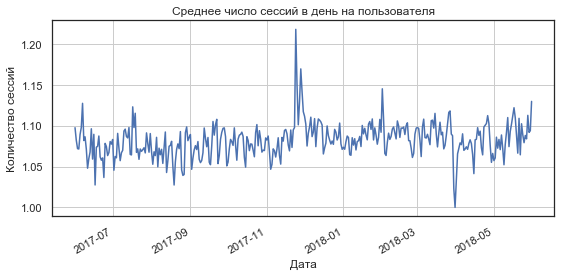

In [48]:
#посчитаем сколько сессий в день приходится на одного пользователя
sessions_per_user = visits.groupby('session_date').agg({'uid': ['count', 'nunique']})
sessions_per_user.columns = ['number_of_sessions', 'number_of_users']
sessions_per_user['sessions_per_user'] = sessions_per_user['number_of_sessions'] / sessions_per_user['number_of_users']

sessions_per_user['sessions_per_user'].plot(figsize = (9,4))
plt.grid()
plt.title('Среднее число сессий в день на пользователя')
plt.xlabel('Дата')
plt.ylabel('Количество сессий')
plt.show()

In [49]:
sessions_per_user['sessions_per_user'].mean()

1.0821696440039723

#### Выводы
1. В среднем пользователь совершает 1 сессию в день.

#### <a id='23'></a> 2.3. Сколько длится одна сессия?

In [50]:
#оставим только те сессии, у которых дата начала меньше даты конца
visits = visits.loc[(visits['start_ts'] <= visits['end_ts'])].copy()

#найдем продолжительность сессии в секундах
visits['session_length_sec'] = (visits['end_ts'] - visits['start_ts']).astype('timedelta64[s]')

In [51]:
visits['session_length_sec'].describe()

count    359398.000000
mean        643.042287
std         997.105212
min           0.000000
25%         120.000000
50%         300.000000
75%         840.000000
max       42660.000000
Name: session_length_sec, dtype: float64

In [52]:
np.percentile(visits['session_length_sec'], [90, 95, 99, 99.9])

array([1620., 2280., 4500., 9840.])

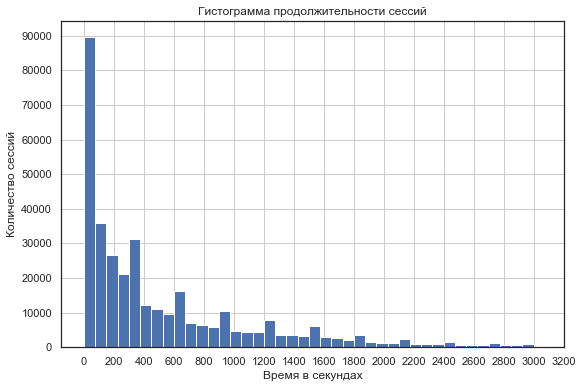

In [53]:
visits['session_length_sec'].hist(range=(0, 3000), bins=40, figsize = (9,6))
plt.title('Гистограмма продолжительности сессий')
plt.xlabel('Время в секундах')
plt.ylabel('Количество сессий')
plt.xticks(range(0, 3400, 200))
plt.yticks(range(0, 100000, 10000))
plt.show()

#### Выводы

1. При оценке средней длины сессии будем ориентироваться на медиану, т.к. на графике наблюдается длинный "хвост". Медианное значение длины сессии - 5 минут. 
2. В данных присутствует аномально большое значение длины сессии - около 10 часов.
3. Меньше 0.1% пользователей провели на сайте больше 3х часов.

#### <a id='24'></a> 2.4. Как часто люди возвращаются?

In [54]:
#найдем дату первой сессии, источник с которого пришел пользователь в первый раз (первый истоник),
#устройство, которое использовал пользователь при первой сессии (первое устройство)
#для каждого пользователя
visits_first = visits.sort_values(by = ['uid','start_ts'])

visits_first = visits_first.groupby('uid').agg({'start_ts': 'first', 
                                                'device': 'first', 
                                                'source_id': 'first'})

visits_first.columns = ['first_session', 'first_device','first_source']

#сформируем месячные когорты
visits_first['first_session_month'] = visits_first['first_session'].astype('datetime64[M]')

visits = visits.merge(visits_first, on = 'uid')

#вычислим время жизни когорты
visits['cohort_lifetime'] = visits['session_month'] - visits['first_session_month']
visits['cohort_lifetime'] = round(visits['cohort_lifetime'] / np.timedelta64(1, 'M'))
visits['cohort_lifetime'] = visits['cohort_lifetime'].astype('int')

In [55]:
#функция для подсчета retention rate и создания тепловой карты
def calculate_retention_rate_and_plot_heatmap(cohort_attribute, figure_size, title, title_ylabel):
#делаем когорты по соответствующему атрибуту
    cohorts = (visits
               .groupby([cohort_attribute, 'cohort_lifetime'])
               .agg({'uid': 'nunique'})
               .reset_index())

#записываем в cohorts_initially количество пользователей в 0 lifetime
    cohorts_initially = cohorts[cohorts['cohort_lifetime'] == 0][[cohort_attribute, 'uid']]
    cohorts_initially = cohorts_initially.rename(columns = {'uid': 'number_of_customers'})

    cohorts = cohorts.merge(cohorts_initially, on = cohort_attribute)

    cohorts['retention'] = cohorts['uid'] / cohorts['number_of_customers']

    retention_pivot = cohorts.pivot_table(
        index = cohort_attribute, 
        columns = 'cohort_lifetime', 
        values = 'retention',
        aggfunc = 'sum')
    
    if cohort_attribute == 'first_session_month':
        retention_pivot.index = retention_pivot.index.strftime('%b %Y')
        
#рисуем тепловую карту
    sns.set(style = 'white')
    plt.figure(figsize = (figure_size))
   
    sns.heatmap(retention_pivot, 
                annot = True, 
                fmt = '.2%', 
                linewidths = 1, 
                linecolor = 'gray', 
                annot_kws={"fontsize": 10});
    
    plt.title(title)
    plt.xlabel('Время жизни когорты')
    plt.ylabel(title_ylabel)
    plt.yticks(rotation=0)    

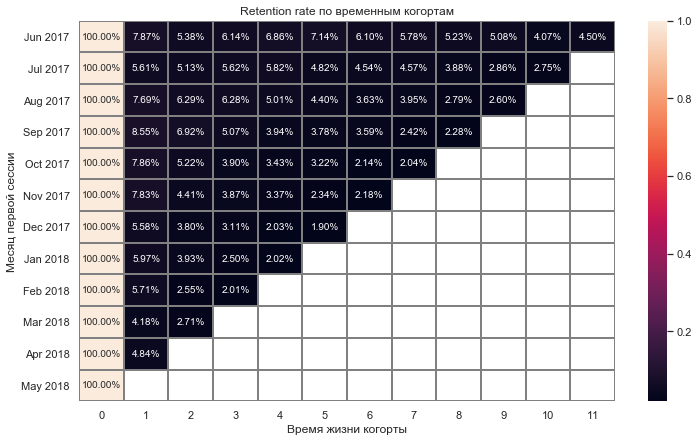

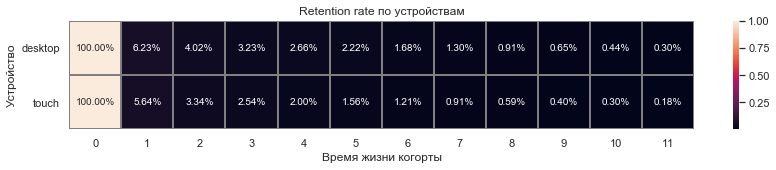

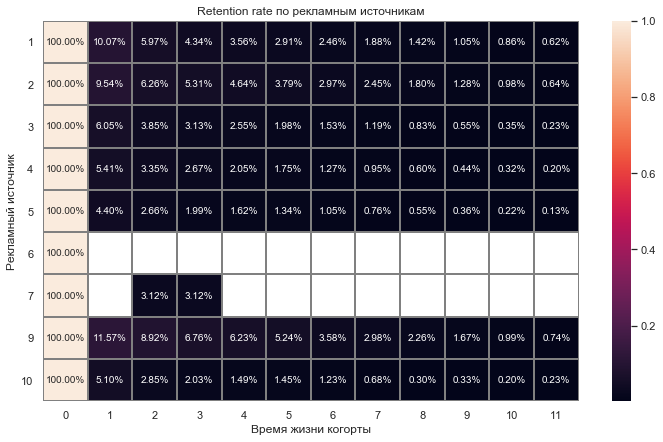

In [56]:
calculate_retention_rate_and_plot_heatmap('first_session_month', 
                                          (12, 7), 
                                          'Retention rate по временным когортам',
                                          'Месяц первой сессии')

calculate_retention_rate_and_plot_heatmap('first_device', 
                                          (14, 2), 
                                          'Retention rate по устройствам', 
                                          'Устройство')

calculate_retention_rate_and_plot_heatmap('first_source', 
                                          (12,7), 
                                          'Retention rate по рекламным источникам',
                                          'Рекламный источник')

#### Выводы
1. Коэффициент удержания довольно низкий. Меньше 10% пользователей вернулись на сайт, после месяца использования.
2. Наиболее высокий retention rate в первый месяц у когорты пользователей, пришедших в сентябре 2017 г. - 8.55%.
3. Для когорт пользователей, пришедших в июне и июле 2017 г. характерен небольшой рост retention rate в последющие месяцы.
4. Для всех остальных когорт наблюдается стабильное снижение retention rate на 1-3% в последующие месяцы использования.
5. Для мартовских и апрельский когорт 2018 г. retention rate после месяца использования составляет 4.2% и 4.8%, что ниже чем у всех предыдущих когорт.
6. Коэффициент удержания когорты пользователей desktop выше(6.23%), чем у когорты пользователей touch(5.64%)
7. Самый выскокий коэффициент удержания у пользователей, пришедших из рекламных источников №9 (11.57%), №1(10.07%), №2(9.54%).
8. Самый низкий retention rate у пользователей, пришедших из рекламного источника №5(4.4%).
9. Пользователи, пришедшие из рекламного источника №6, больше не вернулись в приложение.

### <a id='3'></a>3. Метрики продаж

#### <a id='31'></a>3.1. Когда люди начинают покупать?

In [57]:
#присоединим к покупкам дату первого визита пользователя
orders_first_visit = visits_first.merge(orders, on = 'uid')

#создадим таблицу, содержащую идентификатор пользователя, дату первой покупки и дату первой сессии
first_order_first_visit = (orders_first_visit
                           .groupby('uid')
                           .agg({'buy_ts': 'min', 'first_session': 'min'}))

#посчитаем через сколько времени после визита на сайт, пользователь совершил первую покупку
first_order_first_visit['order_interval'] =  (first_order_first_visit['buy_ts'] - 
                                              first_order_first_visit['first_session'])

first_order_first_visit['order_interval'].describe()

count                      36522
mean     16 days 21:40:50.532281
std      47 days 01:45:34.984683
min              0 days 00:00:00
25%              0 days 00:04:00
50%              0 days 00:16:00
75%              2 days 00:17:30
max            363 days 07:04:00
Name: order_interval, dtype: object

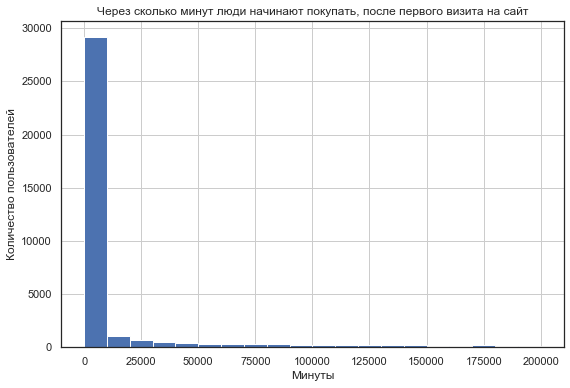

In [58]:
((first_order_first_visit['order_interval'] 
  / 
  np.timedelta64(1, 'm'))
 .hist(bins = 20, 
       range = (0, 200000), 
       figsize = (9 ,6)))

plt.title('Через сколько минут люди начинают покупать, после первого визита на сайт')
plt.xlabel('Минуты')
plt.ylabel('Количество пользователей')
plt.show()

#### Выводы
1. Пользователи в среднем совершают первую покупку через 16 мин. после первого визита на сайт.
2. Присутствуют пользователи, совершившие покупку через 0 сек. после первого визита на сайт. Возможно в некоторых случаях, информация о времени покупке заносится некорректно.

#### <a id='32'></a>3.2. Сколько раз покупают за период?

In [59]:
#создадим дополнительные колонки
orders_first_visit['buy_month'] = orders_first_visit['buy_ts'].astype('datetime64[M]')
orders_first_visit['buy_date'] = orders_first_visit['buy_ts'].astype('datetime64[D]')
orders_first_visit['buy_week'] = (orders_first_visit['buy_date'] - 
                                  pd.to_timedelta(orders_first_visit['buy_ts'].dt.dayofweek, unit='d'))

In [60]:
periods_of_purchases = [['buy_month', 'месяц'], ['buy_week', 'неделю'], ['buy_date', 'день']]

for period in periods_of_purchases:
    purchases_per_period = (orders_first_visit.pivot_table(index = period[0],
                                                           values = 'uid',
                                                           aggfunc = ('count', 'nunique')))

    purchases_per_period['mean'] = purchases_per_period['count'] / purchases_per_period['nunique']

    print('Среднее число покупок на одного пользователя за', 
          period[1] + 
          ': ' +
          str(round(purchases_per_period['mean'].mean(),2)))

Среднее число покупок на одного пользователя за месяц: 1.22
Среднее число покупок на одного пользователя за неделю: 1.16
Среднее число покупок на одного пользователя за день: 1.08


#### Выводы
1. Один пользователь в среднем совершает одну покупку в месяц/неделю/день.

#### <a id='33'></a>3.3. Какой средний чек?

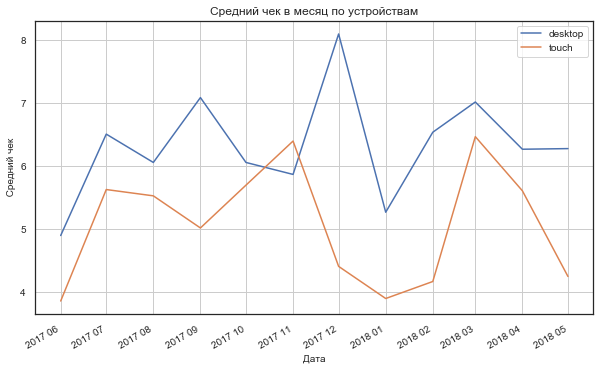

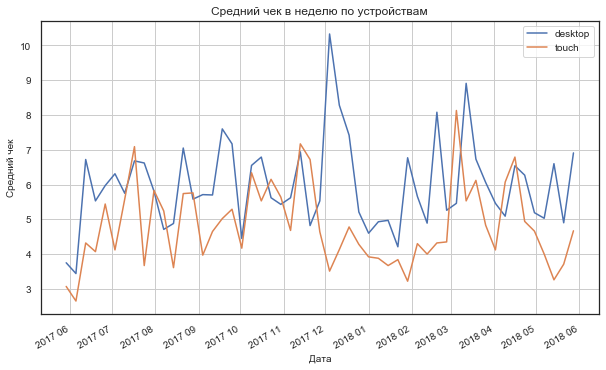

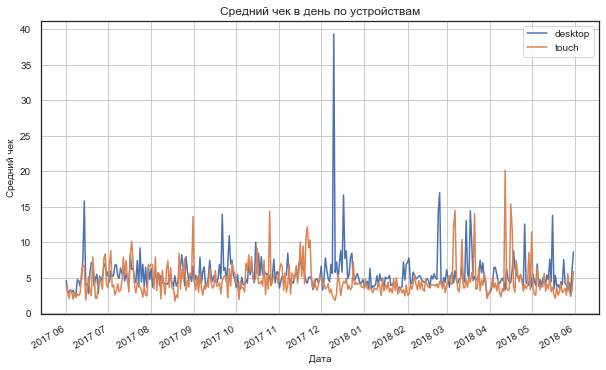

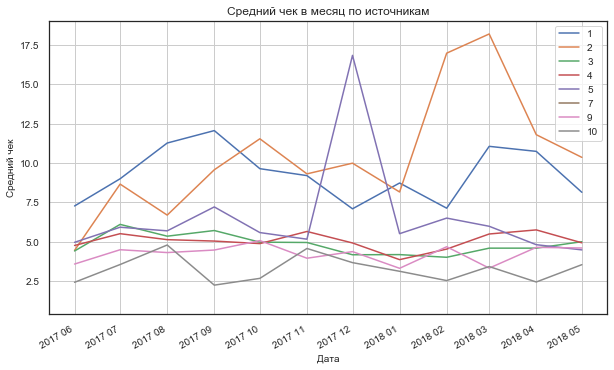

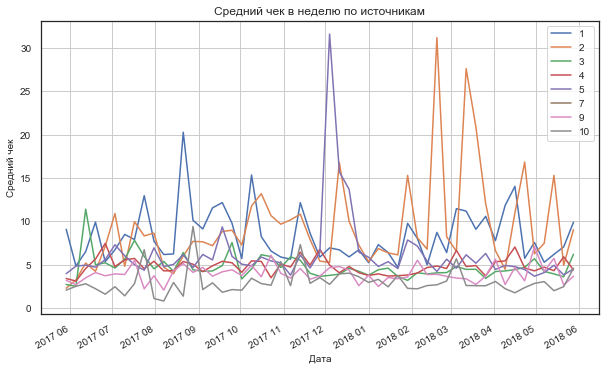

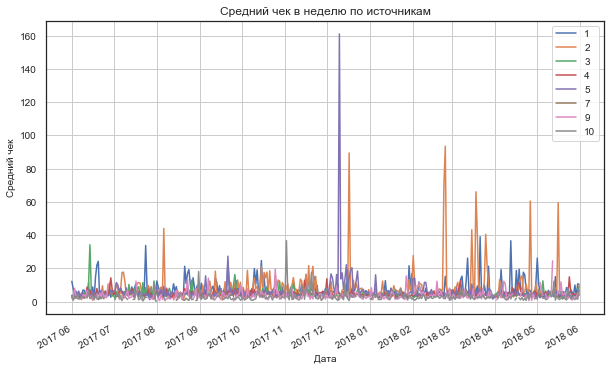

In [61]:
#отобразим на графиках средний чек на одного покупателя в разрезе первого устройства покупателя
#и первого рекламного источника
data_to_plot = [['buy_month', 'first_device', 'Средний чек в месяц по устройствам', ' Средний чек'],
                ['buy_week', 'first_device', 'Средний чек в неделю по устройствам', 'Средний чек'],
                ['buy_date', 'first_device', 'Средний чек в день по устройствам', 'Средний чек'],
                ['buy_month', 'first_source', 'Средний чек в месяц по источникам', 'Средний чек'],
                ['buy_week', 'first_source', 'Средний чек в неделю по источникам', 'Средний чек'],
                ['buy_date', 'first_source', 'Средний чек в неделю по источникам', 'Средний чек']]

for data in data_to_plot:
    pivot_table1 = orders_first_visit.pivot_table(index = data[0],
                                                  columns = data[1],
                                                  values = 'revenue',
                                                  aggfunc = 'sum')

    pivot_table2 = orders_first_visit.pivot_table(index = data[0],
                                                  columns = data[1],
                                                  values = 'uid',
                                                  aggfunc = 'nunique')    
    
    pivot_to_plot = round(pivot_table1 / pivot_table2, 2)
    make_plot_from_pivot(pivot_to_plot, data[2], data[3])

#### Выводы
1. Средний месячный и недельный чек пользователей destkop, выше, чем у пользователей touch.
2. Средний месячный и недельный чек выше у пользователей, которые пришли на сайт с рекламных источников №1 и №2.
3. На графике среднего чека под дням по источникам рекламы, виден большой всплеск из рекламного источника №5, в начале декабря. На протяжении года наблюдаются периодические всплески у рекламного источника №2 (в районе 23 февраля, в середине мая). У остальных - средний чек колеблется в одинаковом диапазоне.

#### <a id='34'></a>3.4. Сколько денег приносят? (LTV)

In [62]:
#добавим время жизни
orders_first_visit['age'] = (((orders_first_visit['buy_month'] - 
                               orders_first_visit['first_session_month']) / 
                               np.timedelta64(1, 'M'))
                               .round()
                               .astype('int'))

#функция, считающая количество покупателей для когорты
def count_users_by_cohorts(cohort_attribute):
    number_of_users_by_attribute = orders_first_visit.groupby(cohort_attribute)['uid'].nunique()
    number_of_users_by_attribute.name = 'number_of_users'
    number_of_users_by_attribute = number_of_users_by_attribute.reset_index()
    
    return number_of_users_by_attribute


#посчитаем количество покупателей для наших когорт
number_of_users_by_months = count_users_by_cohorts('first_session_month')

number_of_users_by_devices = count_users_by_cohorts('first_device')

number_of_users_by_sources = count_users_by_cohorts('first_source')

In [63]:
#функция считающая LTV
def count_ltv_by_cohorts(cohort_attribute, cohort_number_of_users):
    revenue_by_cohort_and_age = (orders_first_visit
                                 .groupby(['age', cohort_attribute])['revenue']
                                 .sum()
                                 .reset_index())

    #Добавим в таблицу данные о том, сколько людей в когортах
    cohorts_ltv = revenue_by_cohort_and_age.merge(cohort_number_of_users, on = cohort_attribute)

    cohorts_ltv['ltv'] = (cohorts_ltv['revenue'] / cohorts_ltv['number_of_users']).round(2)
    
    return cohorts_ltv


#посчитаем LTV для наших когорт
cohorts_by_months_ltv = count_ltv_by_cohorts('first_session_month', number_of_users_by_months)

cohorts_by_devices_ltv = count_ltv_by_cohorts('first_device', number_of_users_by_devices)

cohorts_by_sources_ltv = count_ltv_by_cohorts('first_source', number_of_users_by_sources)

In [64]:
cohorts_to_pivot = [[cohorts_by_months_ltv, 'first_session_month', 'Накопительное LTV когорты по месяцам'], 
                    [cohorts_by_devices_ltv, 'first_device', 'Накопительное LTV когорты по устройствам'],  
                    [cohorts_by_sources_ltv, 'first_source', 'Накопительное LTV когорты по источникам']]

for cohorts in cohorts_to_pivot:
    print(cohorts[2])
    display(cohorts[0].pivot_table(index = cohorts[1], 
                                   columns = 'age', 
                                   values = 'ltv', 
                                   aggfunc = 'mean')
            .cumsum(axis=1)
            .round(2)
            .fillna(''))
    
print('LTV средней когорты по месяцам')
display(cohorts_by_months_ltv.pivot_table(index = 'first_session_month',
                                          columns = 'age',
                                          values = 'ltv',
                                          aggfunc = 'mean')
        .cumsum(axis=1)
        .mean(axis=0)
        .round(2))

Накопительное LTV когорты по месяцам


age,0,1,2,3,4,5,6,7,8,9,10,11
first_session_month,,,,,,,,,,,,
2017-06-01,3.27,4.18,4.68,6.01,7.36,8.33,9.52,10.3,11.09,12.28,13.03,13.69
2017-07-01,4.02,4.45,4.9,5.3,5.64,5.96,6.2,6.51,6.8,7.04,7.23,
2017-08-01,3.62,4.2,4.78,5.33,5.8,6.11,6.39,7.11,7.59,7.81,,
2017-09-01,4.04,5.25,5.94,9.35,9.77,10.39,10.71,10.87,11.01,,,
2017-10-01,3.93,4.74,5.02,5.25,5.47,5.69,5.81,5.95,,,,
2017-11-01,3.88,4.51,4.83,5.15,5.41,5.58,5.74,,,,,
2017-12-01,4.14,4.57,5.6,6.86,7.22,7.66,,,,,,
2018-01-01,3.40,4.03,4.4,4.5,4.67,,,,,,,
2018-02-01,3.61,4.23,4.44,4.72,,,,,,,,


Накопительное LTV когорты по устройствам


age,0,1,2,3,4,5,6,7,8,9,10,11
first_device,,,,,,,,,,,,
desktop,4.01,4.64,5.09,5.89,6.22,6.51,6.71,6.86,6.97,7.09,7.17,7.23
touch,3.44,4.12,4.41,4.63,4.80,4.96,5.08,5.24,5.37,5.49,5.53,5.56


Накопительное LTV когорты по источникам


age,0,1,2,3,4,5,6,7,8,9,10,11
first_source,,,,,,,,,,,,
1,5.01,5.91,6.53,7.47,8.05,8.43,8.75,9.51,9.94,10.24,10.52,10.7
2,5.11,6.84,8.56,10.41,11.32,12.03,12.38,12.6,12.81,13.08,13.27,13.38
3,3.60,4.16,4.4,4.61,4.8,4.93,5.03,5.09,5.14,5.17,5.19,5.2
4,3.64,4.07,4.28,4.48,4.65,4.86,5.06,5.13,5.22,5.35,5.43,5.5
5,4.15,4.64,4.93,6.5,6.75,7.06,7.23,7.36,7.44,7.55,7.57,7.58
7,1.22,,,,,,,,,,,
9,2.18,2.76,3.29,3.76,4.18,4.39,4.64,4.82,5.07,5.22,5.27,5.28
10,2.67,2.9,3,3.06,3.19,3.25,3.3,3.32,3.32,3.33,3.34,3.35


LTV средней когорты по месяцам


age
0      3.91
1      4.54
2      4.94
3      5.83
4      6.42
5      7.10
6      7.40
7      8.15
8      9.12
9      9.04
10    10.13
11    13.69
dtype: float64

#### Выводы
1. За год пользования сайтом пользователь первой когорты (июнь 2017 г.) в среднем принес по 13.69.
2. За 6 месяцев в среднем приносят 7.10
3. Больше всего денег за полгода принес средний пользователь когорты сентября 2017 г.
4. Пользователи desktop приносят больше денег: 7.23 за год, чем пользователи touch: 5.56 за год.
5. Больше всего денег за год принес средний пользователь, которые пришли из рекламных источников №2(13.38) и №1 (10.7).
6. Меньше всего денег за год принес средний пользователь из рекламного источника № 10 (3.35)


### <a id='4'></a>4. Метрики маркетинга

#### <a id='41'></a> 4.1. Сколько денег потратили? Всего / на каждый источник / по времени

In [65]:
#потратили всего
display(HTML('<b>Расходы на маркетинг: </b>' 
             + str(costs['costs'].sum())
             + '<hr style="height:1px">'))

#потратили на каждый источник
costs_by_sources = costs.groupby('source_id')['costs'].sum()

display(HTML('<b>Расходы на маркетинг по источникам: </b>'
             + costs_by_sources.reset_index().to_html()))

display(HTML('<br><b>Средние расходы на маркетинг по источникам: </b>'
             + str(round(costs_by_sources.mean())) 
             #+ '</p>' 
             + '<hr style="height:1px">'))

#потратили помесячно
costs['dt_month'] = costs['dt'].astype('datetime64[M]')
costs_by_months = costs.groupby('dt_month')['costs'].sum()

display(HTML('<b>Расходы на маркетинг помесячно: </b>'
             + costs_by_months.reset_index().to_html()))

display(HTML('<b>Средние расходы на маркетинг помесячно: </b>'
             + str(round(costs_by_months.mean()))))

,source_id,costs
0,1,20833.27
1,2,42806.04
2,3,141321.63
3,4,61073.60
4,5,51757.10
5,9,5517.49
6,10,5822.49


,dt_month,costs
0,2017-06-01,18015.00
1,2017-07-01,18240.59
2,2017-08-01,14790.54
3,2017-09-01,24368.91
4,2017-10-01,36322.88
5,2017-11-01,37907.88
6,2017-12-01,38315.35
7,2018-01-01,33518.52
8,2018-02-01,32723.03
9,2018-03-01,30415.27


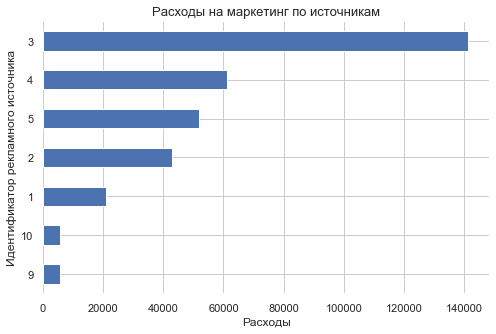

In [66]:
ax = costs_by_sources.sort_values().plot(kind = 'barh', figsize = (8, 5))

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

plt.title('Расходы на маркетинг по источникам', fontsize = 13)
plt.xlabel('Расходы', fontsize = 12)
plt.ylabel('Идентификатор рекламного источника', fontsize = 12)

plt.grid()
plt.show()

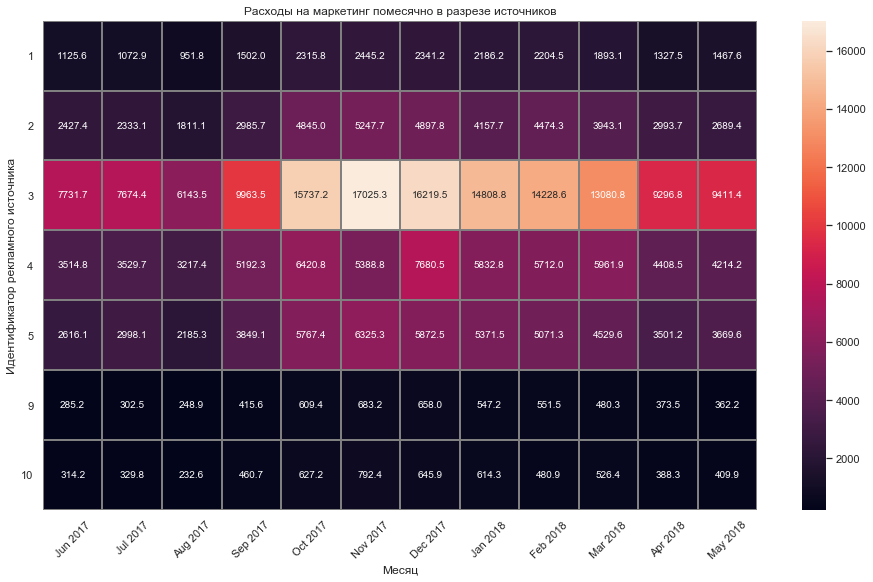

In [67]:
#потратили помесячно в разрезе источников
costs_pivot = costs.pivot_table(index = 'source_id', 
                                columns = 'dt_month', 
                                values = 'costs', 
                                aggfunc = 'sum')

costs_pivot.columns = costs_pivot.columns.strftime('%b %Y')

plt.figure(figsize = (16,9))

sns.set(style = 'white')
sns.heatmap(costs_pivot, 
            annot = True, 
            fmt = '.1f', 
            linewidths = 1, 
            linecolor = 'gray', 
            annot_kws = {"fontsize": 10});

plt.title('Расходы на маркетинг помесячно в разрезе источников')
plt.xlabel('Месяц')
plt.ylabel('Идентификатор рекламного источника')
plt.xticks(rotation = 45)  
plt.yticks(rotation = 0)  

plt.show()

#### Выводы
1. Всего с июня 2017 г. по май 2018 г. компания потратила на маркетинг 329 131.62.
2. Больше всего денег было затрачего на 3 рекламный источник (141 321.63).
3. Значительно меньше денег вкладывается в 9 и 10 источники (5 517 и 5 827). 
4. За данный период в реламные источники № 6,7,8 деньги не вкладывались.
5. С июня 2017 года компания увеличивала расходы на маркентинг. В ноября-декабре 2017 года в маркетинг вкладывалось больше всего денег (около 38 000). С января 2018 года расходы на маркетинг постепенно падают. Возможно это связано с сезонностью: люди чаще посещают мероприятия в холодные месяцы года.
6. В среднем компания тратит 27 427 помесячно на маркетинг.


#### <a id='42'></a> 4.2. Сколько стоило привлечение одного покупателя из каждого источника? (CAC)

In [68]:
def calculate_cac(number_of_users, costs, column_to_merge_on):
    cohorts_cac = (pd.merge(number_of_users,
                            costs,
                            left_on = column_to_merge_on,
                            right_index = True))
    cohorts_cac['cac'] = (cohorts_cac['costs'] / cohorts_cac['number_of_users']).round(2)
    return cohorts_cac
    
    
cohorts_by_months_cac =  calculate_cac(number_of_users_by_months,
                                       costs_by_months, 
                                       'first_session_month')


cohorts_by_sources_cac = calculate_cac(number_of_users_by_sources,
                                       costs_by_sources, 
                                       'first_source')

In [69]:
#расчет стоимости привлечения по устройствам

#найдем затраты на маркентинг по разным источникам по дням
costs_by_day_and_source = costs.groupby(['dt', 'source_id'])['costs'].sum().reset_index()
costs_by_day_and_source.columns = ['first_session_day', 'first_source', 'costs_sum']

#посчитаем количество пользователей за каждый день
orders_first_visit['first_session_day'] = orders_first_visit['first_session'].astype('datetime64[D]')
number_of_users_by_day = count_users_by_cohorts(['first_session_day', 'first_source'])

#найдем среднюю стоимость привлечения одного пользователя по дням и источникам
costs_per_user = number_of_users_by_day.merge(
    costs_by_day_and_source,
    on = ['first_session_day', 'first_source'])

costs_per_user['cost_per_user'] = (costs_per_user['costs_sum'] / 
                                   costs_per_user['number_of_users']).round(2)

costs_per_user = costs_per_user[['first_session_day', 'first_source', 'cost_per_user']]

#добавим в таблицу orders_first_visit стоимость привлечения пользователя
orders_first_visit = (orders_first_visit
                      .merge(costs_per_user,
                             on = ['first_session_day', 'first_source']))

#рассчитаем CAC по устройствам: сгруппируем пользователей по первому устройству
#найдем стоимость привлечения всех пользователей и количество пользователей
cohorts_by_devices_cac = (orders_first_visit
                          .groupby('first_device')
                          .agg({'uid': 'nunique', 'cost_per_user': 'sum'}))


cohorts_by_devices_cac['cac'] = (cohorts_by_devices_cac['cost_per_user'] / 
                                 cohorts_by_devices_cac['uid'])

In [70]:
cohorts_by_months_cac

,first_session_month,number_of_users,costs,cac
0,2017-06-01,2923,18015.00,6.16
1,2017-07-01,2458,18240.59,7.42
2,2017-08-01,1721,14790.54,8.59
3,2017-09-01,3058,24368.91,7.97
4,2017-10-01,4678,36322.88,7.76
5,2017-11-01,4262,37907.88,8.89
6,2017-12-01,4074,38315.35,9.40
7,2018-01-01,3119,33518.52,10.75
8,2018-02-01,3186,32723.03,10.27
9,2018-03-01,2838,30415.27,10.72


In [71]:
cohorts_by_sources_cac

,first_source,number_of_users,costs,cac
0,1,2899,20833.27,7.19
1,2,3506,42806.04,12.21
2,3,10473,141321.63,13.49
3,4,10295,61073.60,5.93
4,5,6931,51757.10,7.47
6,9,1088,5517.49,5.07
7,10,1329,5822.49,4.38


In [72]:
cohorts_by_devices_cac

,uid,cost_per_user,cac
first_device,,,
desktop,29209,363427.51,12.442313
touch,7312,82354.02,11.262858


#### <a id='43'></a>4.3. На сколько окупились расходы? (ROMI)

In [73]:
def calculate_romi(table_cac, table_ltv, cohort_attribute):
    table_cac = table_cac.reset_index()[[cohort_attribute, 'cac']]
    table_romi = (pd.merge(table_ltv,
                           table_cac,
                           on = cohort_attribute))
    table_romi['romi'] = table_romi['ltv'] / table_romi['cac']
    
    report_romi = table_romi.pivot_table(
        index = cohort_attribute, 
        columns = 'age',
        values = 'romi',
        aggfunc ='mean')
    return report_romi
    
report_cohorts_by_months_romi = calculate_romi(cohorts_by_months_cac, 
                                               cohorts_by_months_ltv, 
                                               'first_session_month')

report_cohorts_by_sources_romi = calculate_romi(cohorts_by_sources_cac, 
                                                cohorts_by_sources_ltv, 
                                                'first_source')

report_cohorts_by_devices_romi = calculate_romi(cohorts_by_devices_cac, 
                                                cohorts_by_devices_ltv, 
                                                'first_device')


reports_to_display = [report_cohorts_by_months_romi, 
                      report_cohorts_by_sources_romi, 
                      report_cohorts_by_devices_romi]

for report in reports_to_display:
    display(report.cumsum(axis=1).round(2).fillna(''))

print('Romi средней когорты по месяцам: \n', 
      report_cohorts_by_months_romi.cumsum(axis=1).mean(axis=0).round(2))

print('Romi средней когорты по источникам: \n', 
      report_cohorts_by_sources_romi.cumsum(axis=1).mean(axis=0).round(2))

age,0,1,2,3,4,5,6,7,8,9,10,11
first_session_month,,,,,,,,,,,,
2017-06-01,0.53,0.68,0.76,0.98,1.19,1.35,1.55,1.67,1.8,1.99,2.12,2.22
2017-07-01,0.54,0.6,0.66,0.71,0.76,0.8,0.84,0.88,0.92,0.95,0.97,
2017-08-01,0.42,0.49,0.56,0.62,0.68,0.71,0.74,0.83,0.88,0.91,,
2017-09-01,0.51,0.66,0.75,1.17,1.23,1.3,1.34,1.36,1.38,,,
2017-10-01,0.51,0.61,0.65,0.68,0.7,0.73,0.75,0.77,,,,
2017-11-01,0.44,0.51,0.54,0.58,0.61,0.63,0.65,,,,,
2017-12-01,0.44,0.49,0.6,0.73,0.77,0.81,,,,,,
2018-01-01,0.32,0.37,0.41,0.42,0.43,,,,,,,
2018-02-01,0.35,0.41,0.43,0.46,,,,,,,,


age,0,1,2,3,4,5,6,7,8,9,10,11
first_source,,,,,,,,,,,,
1,0.70,0.82,0.91,1.04,1.12,1.17,1.22,1.32,1.38,1.42,1.46,1.49
2,0.42,0.56,0.70,0.85,0.93,0.99,1.01,1.03,1.05,1.07,1.09,1.10
3,0.27,0.31,0.33,0.34,0.36,0.37,0.37,0.38,0.38,0.38,0.38,0.39
4,0.61,0.69,0.72,0.76,0.78,0.82,0.85,0.87,0.88,0.90,0.92,0.93
5,0.56,0.62,0.66,0.87,0.90,0.95,0.97,0.99,1.00,1.01,1.01,1.01
9,0.43,0.54,0.65,0.74,0.82,0.87,0.92,0.95,1.00,1.03,1.04,1.04
10,0.61,0.66,0.68,0.70,0.73,0.74,0.75,0.76,0.76,0.76,0.76,0.76


age,0,1,2,3,4,5,6,7,8,9,10,11
first_device,,,,,,,,,,,,
desktop,0.32,0.37,0.41,0.47,0.50,0.52,0.54,0.55,0.56,0.57,0.58,0.58
touch,0.31,0.37,0.39,0.41,0.43,0.44,0.45,0.47,0.48,0.49,0.49,0.49


Romi средней когорты по месяцам: 
 age
0     0.44
1     0.52
2     0.58
3     0.71
4     0.80
5     0.91
6     0.98
7     1.10
8     1.25
9     1.28
10    1.54
11    2.22
dtype: float64
Romi средней когорты по источникам: 
 age
0     0.51
1     0.60
2     0.66
3     0.76
4     0.81
5     0.84
6     0.87
7     0.90
8     0.92
9     0.94
10    0.95
11    0.96
dtype: float64


#### Выводы
1. В среднем когорты окупаются на 8 месяце жизни.
2. Рекламные источники, которые окупились в течение года жизни: №1 (окупился на 4 месяце), №2 (окупился на 7 месяце), № 5 и №9 (окупились на 9 месяце).
3. Не окупились источники №3 (на 12 месяц жизни ROMI - 0.39), №10 (на 12 месяц жизни ROMI - 0.76) , №4 (на 12 месяц жизни ROMI - 0.93)
4. ROMI по устройствам примерно одинаков: для desktop (0.58) и для touch (0.49).

### <a id='5'></a>5. Общий вывод

1. Источник №3 самый убыточный: в него вкладывается больше всего денег (CAC - 13.49), из него приходит больше всего пользователей, но он хуже всего окупается (ROMI - 0.39).  Для того, чтобы вложения окупились за полгода, стоимость привлечения не должна превышать 4.93. 
2. Пользователи, пришедшие с рекламных источников №1 и №2 имеют самый большой средний чек и данные источники окупаются на 4 и 7 месяце жизни соответственно. Можно увеличить вложения в данные каналы.
3. Пользователи чаще пользуются десктопной версией сервиса. Возможно, в приложении на touch не так удобно совершать покупку, осуществлять поиск или выбирать места. 
4. Retention rate довольно низкий: менее 10% пользователей возвращаются на сайт после первого месяца использования. Имеет смысл получить feedback от пользователей и выяснить почему они перестают пользоваться сервисом. Возможно есть проблемы в тех. поддержке пользователей.
5. Много пользователей проводят на сайте 1 минуту. Довольно маленькое время для того, чтобы выбрать интересующее событие, места, дату. Возможно эти пользователи заходят не для покупки, а для просмотра имеющихся мероприятий. Можно попробовать сделать кнопку покупки более заметной.